In [1]:
import tensorflow as tf
import pandas as pd
import typing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union, Tuple, List
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#!unzip drive/MyDrive/project2.zip

In [3]:
class FD_Network(tf.keras.Model):
    """
    network to train a model approximating the Weidmann Model on given data
    """
    def __init__(self, dropout_rate=0.1):
        """
        initialize the network, very simple feed forward network with 3 parameter outputs
        :param dropout_rate: rate of dropout to be used
        """
        super(FD_Network, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(10, activation='softplus')
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        # output layers producing the 3 parameters of the FD
        self.desired_speed = tf.keras.layers.Dense(1, activation='softplus')
        self.pedestrian_size = tf.keras.layers.Dense(1, activation='softplus')
        self.time_gap = tf.keras.layers.Dense(1, activation='softplus')
        self.FD_model_parameters = {'t': [], 'l': [], 'v0': []}
        self.mse = -1

    def call(self, mean_spacing):
        """
        execute the feedforward, create the fd function from the parameters, return the predicted speed
        :param mean_spacing: only input of the net
        :return: predicted speed
        """
        x = self.hidden_layer(mean_spacing)
        x = self.dropout(x)
        v0 = self.desired_speed(x)
        l = self.pedestrian_size(x)
        t = self.time_gap(x)
        self.FD_model_parameters['t'].append(tf.math.reduce_mean(t, 0))
        self.FD_model_parameters['l'].append(tf.math.reduce_mean(l, 0))
        self.FD_model_parameters['v0'].append(tf.math.reduce_mean(v0, 0))
        return v0 * (1 - tf.exp((l - mean_spacing) / (v0 * t)))


In [4]:
def read_dataset(path: str) -> (np.ndarray, np.ndarray):
    """
    Read the complete dataset to be fed to the NN
    :param path: path of the pickle file containing the dataset
    :param fd_training: if True keep also k nearest neighbour for input, False leaves only mean spacing for FDNetwork
    :return: data and targets in the form of 2 numpy ndarrays
    """
    #col_names = ["timestep", "ID", "X", "Y", "speed", "mean_spacing"]
    dataset = pd.read_csv(path, sep=" ", header=None)
    dataset.columns=dataset.iloc[0]
    dataset = dataset[1:]
    targets = dataset[['speed']].to_numpy()
    mean_spacing = dataset[['mean_spacing']].to_numpy()
   
    return mean_spacing.astype(float), targets.astype(float)

In [51]:
def run_pedestrian_speed_prediction_model(data_path: str,test_data=None, test_targets=None):
    """
    Trains and returns the pedestrian speed prediction model
    :param data_path: path of the file containing the data
    :param test_data: test data
    :param test_targets: targets for the test data
    :return trained model
    """
    fd_data, fd_targets = read_dataset(data_path)

    # to stop the computation when model is at its cap
    callback = EarlyStopping(monitor='loss', patience=10)  # default on val_loss

    # train the model
    model = FD_Network()
    model.compile(optimizer='adam', loss='mse', run_eagerly=False)
    model.fit(x=fd_data, y=fd_targets, epochs=50, verbose=1, callbacks=[callback])

    if test_data is not None and test_targets is not None:
        model.mse = np.mean((model.predict(test_data) - test_targets) ** 2)

    return model

def visualize_pedestrian_speed_prediction_model(model, data_path: str, test_data=None, test_targets=None):
    """
    Plots the observed speeds and the ones predicted by the pedestrian speed prediction model
    :param model: trained model
    :param data_path: path of the file containing the data
    :param test_data: test data
    :param test_targets: targets for the test data
    """
    fd_data, fd_targets = read_dataset(data_path)
    stop = np.max(fd_data) * 1.5
    mean_spacings = np.expand_dims(np.linspace(start=0.5, stop=stop, num=1000), axis=1)
    if test_data is not None:
        mean_spacings = test_data
    speeds = model.predict(x=mean_spacings)
    if test_targets is not None:
        model.mse = np.mean((speeds - test_targets) ** 2)
      
    fd_data_1 = fd_data.flatten()
    fd_targets_1 = fd_targets.flatten()

    df1 = pd.DataFrame({'x': fd_data_1, 'y': fd_targets_1})
    sns.scatterplot(x='x', y='y', data=df1)

    df = pd.DataFrame({'Mean Spacings': mean_spacings.flatten(), 'Speeds': speeds.flatten()})
    sns.scatterplot(x='Mean Spacings', y='Speeds', data=df)
    


In [6]:
path_corridor = './project2/corridor_both_directions_revised_dataset.txt'
path_left_turn = './project2/left_turn_revised_dataset.txt'
path_supermarket = './project2/supermarket_revised_dataset.txt'

In [7]:
fd_data, fd_targets = read_dataset(path_corridor)

Epoch 1/50
216/216 [==============================] - 3s 3ms/step - loss: 0.0561
Epoch 2/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0341
Epoch 3/50
216/216 [==============================] - 1s 3ms/step - loss: 0.0320
Epoch 4/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0317
Epoch 5/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0298
Epoch 6/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 7/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 8/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 9/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0289
Epoch 10/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0283
Epoch 11/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 12/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 13/50
216/216 [====

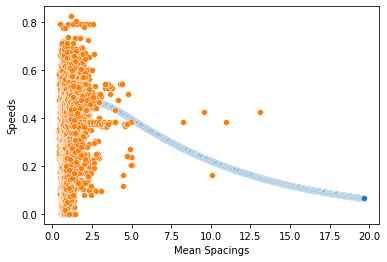

In [47]:
model = run_pedestrian_speed_prediction_model(path_corridor)
visualize_pedestrian_speed_prediction_model(model,path_corridor)

Epoch 1/50
276/276 [==============================] - 1s 2ms/step - loss: 0.1106
Epoch 2/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0404
Epoch 3/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0316
Epoch 4/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 5/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 6/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0258
Epoch 7/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 8/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 9/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 10/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 11/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 12/50
276/276 [==============================] - 0s 2ms/step - loss: 0.0226
Epoch 13/50
276/276 [====

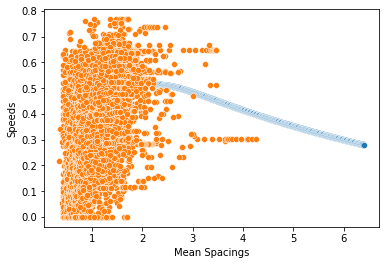

In [49]:
model2 = run_pedestrian_speed_prediction_model(path_left_turn)
visualize_pedestrian_speed_prediction_model(model2,path_left_turn)

Epoch 1/50


<ipython-input-45-4d581d048690>:9: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  fd_data, fd_targets = read_dataset(data_path)


1798/1798 [==============================] - 4s 2ms/step - loss: 0.0247
Epoch 2/50
1798/1798 [==============================] - 3s 2ms/step - loss: 0.0126
Epoch 3/50
1798/1798 [==============================] - 3s 2ms/step - loss: 0.0117
Epoch 4/50
1798/1798 [==============================] - 4s 2ms/step - loss: 0.0114
Epoch 5/50
1798/1798 [==============================] - 3s 2ms/step - loss: 0.0112
Epoch 6/50
1798/1798 [==============================] - 3s 2ms/step - loss: 0.0111
Epoch 7/50
1798/1798 [==============================] - 3s 2ms/step - loss: 0.0111
Epoch 8/50
1798/1798 [==============================] - 4s 2ms/step - loss: 0.0110
Epoch 9/50
1798/1798 [==============================] - 4s 2ms/step - loss: 0.0110
Epoch 10/50
1798/1798 [==============================] - 3s 2ms/step - loss: 0.0110
Epoch 11/50
1798/1798 [==============================] - 3s 2ms/step - loss: 0.0110
Epoch 12/50
1798/1798 [==============================] - 3s 2ms/step - loss: 0.0110
Epoch 13/50


<ipython-input-45-4d581d048690>:32: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  fd_data, fd_targets = read_dataset(data_path)


32/32 [==============================] - 0s 1ms/step


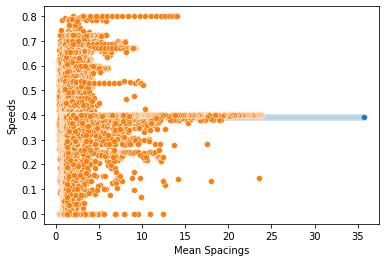

In [48]:
model3 = run_pedestrian_speed_prediction_model(path_supermarket)
visualize_pedestrian_speed_prediction_model(model3,path_supermarket)
